In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
%run './plot_setup.py'

In [124]:
from mpl_toolkits.mplot3d import Axes3D

In [108]:
# Generate the signal using George
import george
from george import kernels

In [413]:
# domain size
l = 1.0
num_pixels = 1000

ndim = 3

pix_x = np.random.random((num_pixels, ndim))

In [414]:
# Input parameters of the Kernel
a = 1.
b = 0.2

In [415]:
# Build the gp object
# The metric for the george kernel is defined such that it scales the square of the distance
metric = np.diag([b ** 2] * ndim)
kernel = a * kernels.ExpSquaredKernel(metric=metric, ndim=ndim)

gp_obj = george.GP(kernel=kernel)

In [416]:
# Sample 
pix_s = gp_obj.sample(pix_x)

In [417]:
# Add noise to the data
pix_nstd = 0.4 * a
pix_n = pix_nstd * np.ones(num_pixels)

# just take d = s
pix_d = pix_s + np.random.normal(loc=0, scale=pix_n)

In [418]:
# store as input data file to dachshund
p = np.vstack([pix_x.T[0], pix_x.T[1], pix_x.T[2], pix_n, pix_d]).T
p.tofile("pixel_data.bin")

<IPython.core.display.Javascript object>


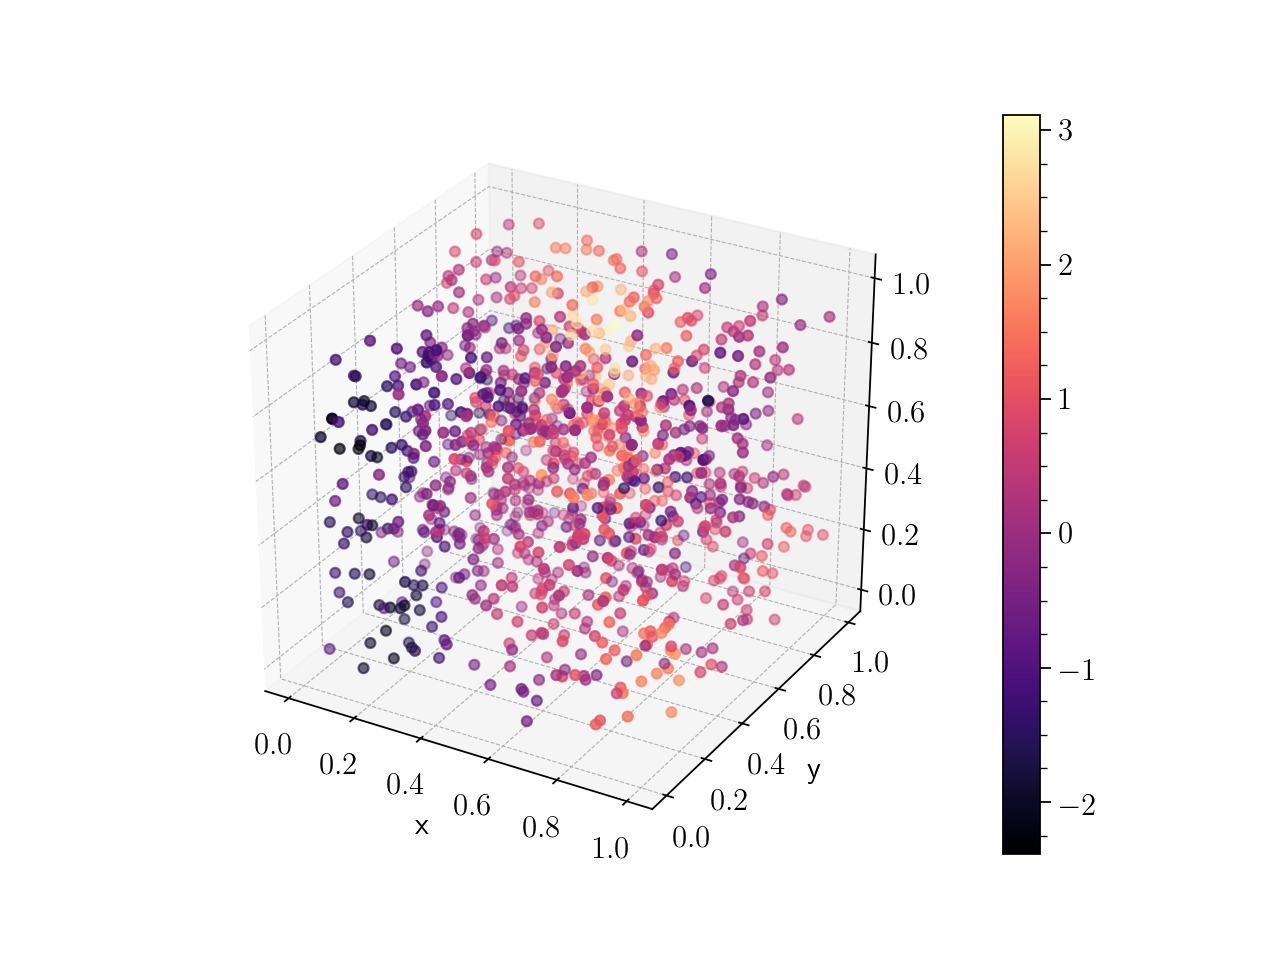

In [430]:
# 3d visualization
s_min = pix_s.min()
s_max = pix_s.max()


fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
# ax2 = fig.add_subplot(122, projection='3d')

cbar1 = ax1.scatter(pix_x[:, 0], pix_x[:, 1], pix_x[:, 2], c=pix_s, vmin=s_min, vmax=s_max, cmap=plt.cm.magma)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

plt.colorbar(cbar1, ax=ax1)
plt.savefig('3d_sample.pdf')

# cbar2 = ax2.scatter(pix_x[:, 0], pix_x[:, 1], pix_x[:, 2], c=pix_d, vmin=-2, vmax=2)
# plt.colorbar(cbar2, ax=ax2)

In [420]:
# map pixels
map_n = 50
dx = l / map_n

ii = np.mgrid[0:map_n, 0:map_n, 0:map_n]
xx = dx * (ii + 0.5)
xx = xx.reshape(3, map_n**3).T

In [421]:
# write config file
cf = open("run.cfg", "w")
cf.write("lx = %f\n" % l)
cf.write("ly = %f\n" % l)
cf.write("lz = %f\n" % l)
cf.write("num_pixels = %i\n" % num_pixels)
cf.write("map_nx = %i\n" % map_n)
cf.write("map_ny = %i\n" % map_n)
cf.write("map_nz = %i\n" % map_n)
cf.write("corr_var_s = 1.0\n")
cf.write("corr_l_perp = %f\n" % b)
cf.write("corr_l_para = %f\n" % b)
cf.write("pcg_tol = 1.0e-5\n")
cf.write("pcg_max_iter = 1000\n")
cf.close()

In [422]:
# Run the dachshund executable
!/Users/vikrant/Programs/dachshund-master/dachshund.exe run.cfg

Reading config file run.cfg.

Running dachshund with:
  pixels/map:
    lx ly lz = 1.000000 1.000000 1.000000
    npix = 1000
    map nx ny nz = 50 50 50, n = 125000
  signal:
    corr var_s = 1.000000
    l_perp = 0.200000    l_para = 0.200000
  WF x solve: 1
  PCG:
    max iter = 1000    step r = 50
    tol = 0.000010
  options:
    map covar = 0
  paths:
    pixel data = pixel_data.bin
    map = map.bin

Reading pixel data.
Preparing for x solve.
Starting solve.
[PCG] Solving 1000 x 1000 problem.
    Goal |r| < (tol) |b| = 8.430826e-04,  delta = 9.803976e+02
    iter 1, |r| 7.940702e+01, delta 8.697208e+02
    iter 2, |r| 8.154667e+01, delta 9.172219e+02
    iter 3, |r| 8.371667e+01, delta 9.666869e+02
    iter 4, |r| 9.197732e+01, delta 1.166873e+03
    iter 5, |r| 9.576631e+01, delta 1.264991e+03
    iter 6, |r| 8.832434e+01, delta 1.076026e+03
    iter 7, |r| 8.482510e+01, delta 9.924549e+02
    iter 8, |r| 1.010289e+02, delta 1.407839e+03
    iter 9, |r| 9.003993e+01, delta 1.11

In [423]:
# get the reconstructed file
gs = (map_n, map_n, map_n)

m = np.fromfile('map.bin')
m_grid = m.reshape(gs)

<IPython.core.display.Javascript object>


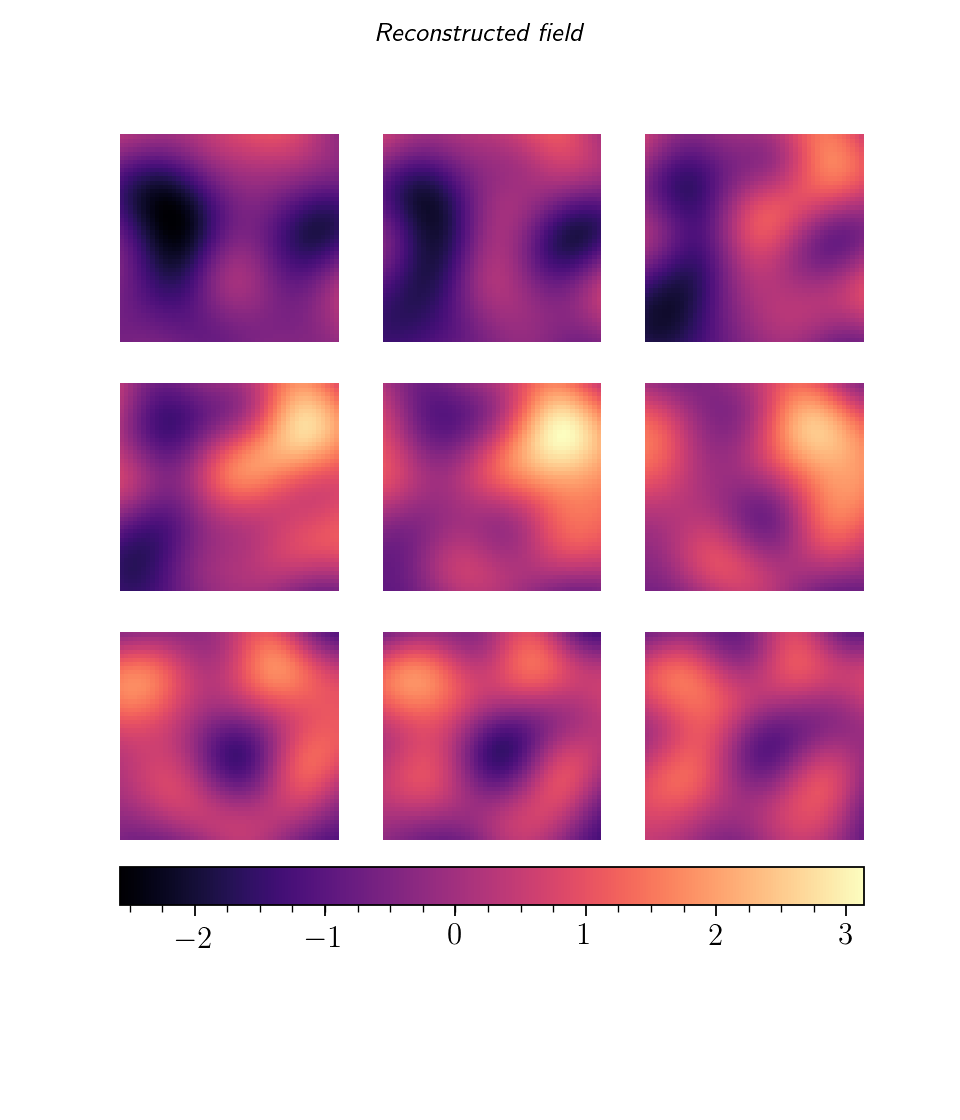

In [432]:
# Appropriate color range for the plots
s_min = m.min()
s_max = m.max()

fig, ax = plt.subplots(3, 3, figsize=(6, 7))

for i in range(9):
    k = np.unravel_index(i, (3, 3))
    cbar = ax[k].pcolormesh((m_grid[i * 5]).T, cmap=plt.cm.magma, vmin=s_min, vmax=s_max)
    ax[k].axis('off')

# Common colorbar for all the subplots
fig.colorbar(cbar, ax=ax.ravel().tolist(), orientation='horizontal')
plt.subplots_adjust(wspace=0.2, hspace=0.2, bottom=0.25)

plt.suptitle(r'\textit{Reconstructed field}')
plt.savefig('3d_recon.pdf')
plt.show()